In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


#DCGAN
Code from the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks". 

#Dataset
I'll be using the CelebA dataset as the ground truth for the probability distribution. The GAN will be trained to generate faces.

In [2]:
!git clone https://github.com/tkarras/progressive_growing_of_gans.git

Cloning into 'progressive_growing_of_gans'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 170 (delta 1), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (170/170), 356.84 KiB | 8.70 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [3]:
!gdown --id 12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg

Downloading...
From: https://drive.google.com/uc?id=12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg
To: /content/CelebA.zip
100% 1.44G/1.44G [00:19<00:00, 73.1MB/s]


In [4]:
!unzip "/content/CelebA.zip" -d "/content/CelebA"

Streaming output truncated to the last 5000 lines.
 extracting: /content/CelebA/img_align_celeba/197600.jpg  
 extracting: /content/CelebA/img_align_celeba/197601.jpg  
 extracting: /content/CelebA/img_align_celeba/197602.jpg  
 extracting: /content/CelebA/img_align_celeba/197603.jpg  
 extracting: /content/CelebA/img_align_celeba/197604.jpg  
 extracting: /content/CelebA/img_align_celeba/197605.jpg  
 extracting: /content/CelebA/img_align_celeba/197606.jpg  
 extracting: /content/CelebA/img_align_celeba/197607.jpg  
 extracting: /content/CelebA/img_align_celeba/197608.jpg  
 extracting: /content/CelebA/img_align_celeba/197609.jpg  
 extracting: /content/CelebA/img_align_celeba/197610.jpg  
 extracting: /content/CelebA/img_align_celeba/197611.jpg  
 extracting: /content/CelebA/img_align_celeba/197612.jpg  
 extracting: /content/CelebA/img_align_celeba/197613.jpg  
 extracting: /content/CelebA/img_align_celeba/197614.jpg  
 extracting: /content/CelebA/img_align_celeba/197615.jpg  
 extr

In [5]:
!pip install tensorflow
!pip install tensorflow_datasets

In [6]:
!sudo du CelebA
!sudo ls CelebA/img_align_celeba | wc -l

1743664	CelebA/img_align_celeba
1743668	CelebA
202599


In [7]:
# Define Generator and Discriminator

import tensorflow as tf

FINAL_DIM = 16
IMAGE_RES = 64
NOISE_DIM = 100

def Generator():
      
  def add_g_layer(x, filters):
    """
    Generator layers are made up of a fractionally-strided convolution 
    ("deconvolution"), BatchNorm, and ReLU activation. 
    """
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

  def output_g_layer(x):
    # Final fractionally-strided convolution ("deconvolution") into image space
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.math.tanh(x)
    return x

  # Define input noise vector shape
  noise_input = tf.keras.layers.Input(shape=(NOISE_DIM))

  # Initial projection into 4x4 feature maps
  x = tf.keras.layers.Dense(4 * 4 * (FINAL_DIM * 8), 
                            activation=None)(noise_input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Reshape((4, 4, (FINAL_DIM * 8)))(x)

  # Generator fractionally-strided convolutional layers
  x = add_g_layer(x, filters=FINAL_DIM * 4)
  x = add_g_layer(x, filters=FINAL_DIM * 2)
  x = add_g_layer(x, filters=FINAL_DIM)

  # Final convolution (convert feature maps into image)
  x = output_g_layer(x)

  # Model definition
  model = tf.keras.Model(inputs=noise_input, outputs=x, name='DCGAN_Generator')

  print(model.summary())

  return model


def Discriminator():

  """
  The Discriminator, for the most part, mirrors, the Generator. Key differences
  are 1) LeakyReLU(0.2) instead of ReLU, and 2) Output FC layer(1) with sigmoid
  activation.
  """

  def add_d_layer(x, filters):
    """
    Discriminator layers are made up of a strided convolutional layer 
    (downsampling without pooling), BatchNorm, and LeakyReLU (leak=0.2)
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size=(5, 5), strides=(2, 2), 
                               padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

  def output_d_layer(x):
    """
    Final layer in Discriminator. Single neuron with sigmoid activation for
    classification of image as fake or real. 
    """
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.sigmoid(x)
    return x

  """Start: Image of dimensions (64, 64, 3). End: Fake/real classification value 
  ranging [0, 1]"""

  image_input = tf.keras.layers.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

  # Discriminator's strided convolutions
  x = add_d_layer(image_input, filters=FINAL_DIM)
  x = add_d_layer(x, filters=FINAL_DIM * 2)
  x = add_d_layer(x, filters=FINAL_DIM * 4)
  x = add_d_layer(x, filters=FINAL_DIM * 8)

  # Discriminator's output layer
  x = output_d_layer(x)

  model = tf.keras.Model(inputs=image_input, outputs=x, 
                         name='DCGAN_Discriminator')

  print(model.summary())

  return model

g = Generator()
d = Discriminator()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 2048)              206848    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)     

In [8]:
!pip install opencv-python

(218, 178, 3)


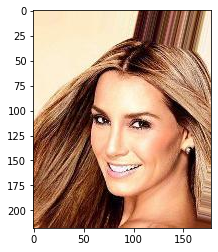

In [9]:
# Test image read

import cv2
import matplotlib.pyplot as plt

# Read in image as ndarray
img = cv2.imread('CelebA/img_align_celeba/000001.jpg')
# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Starting images are 178px resolution
print(img.shape)

# print(img)
plt.imshow(img)

(178, 178, 3)


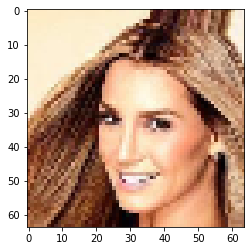

In [10]:

original_img = cv2.imread('CelebA/img_align_celeba/000001.jpg')

# Crop out top and bottom evenly to create a square image
crop_margin = int((original_img.shape[0] - original_img.shape[1]) / 2)
original_img = original_img[crop_margin:(original_img.shape[0] - crop_margin)]

print(original_img.shape)

# Resize to 64x64
img = cv2.resize(original_img, (64, 64))

# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [11]:
!pip install tqdm

In [12]:
# I'm only going to take a subset of the data for now for training

SUBSET_AMOUNT = 10000

In [13]:
# Read images as dataset

import os
import numpy as np
from tqdm import tqdm

ds_list = []

directory = r'/content/CelebA/img_align_celeba'
for filename in tqdm(os.listdir(directory)[:SUBSET_AMOUNT]):

  if filename.endswith('.jpg'):

    # Read in image as ndarray
    img = cv2.imread('CelebA/img_align_celeba/' + filename)

    # Crop out top and bottom evenly to create a square image
    crop_margin = int((img.shape[0] - img.shape[1]) / 2)
    img = img[crop_margin:(img.shape[0] - crop_margin)]

    # Resize to 64x64
    img = cv2.resize(img, (64, 64))

    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ds = np.append(ds, img)
    ds_list.append(img)

ds = np.array(ds_list)

100%|██████████| 10000/10000 [00:18<00:00, 537.27it/s]


In [14]:
# Move all pixel values into the range [-1, 1] (the range of tanh)

ds = (ds / (255.0/2)) - 1.0

In [15]:
ds[0]

array([[[-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        ...,
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]],

       [[-0.98431373, -0.98431373, -0.98431373],
        [-0.98431373, -0.98431373, -0.98431373],
        [-0.98431373, -0.98431373, -0.98431373],
        ...,
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686]],

       [[-0.98431373, -0.98431373, -0.98431373],
        [-0.98431373, -0.98431373, -0.98431373],
        [-0.98431373, -0.98431373, -0.98431373],
        ...,
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686]],

       ...,

       [[-0.23921569, -0.6       , -0.7254902 ],
        [-0

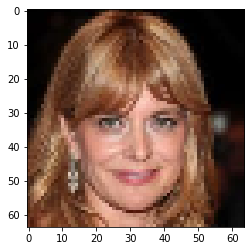

In [16]:
_ = (ds[0]+1.0)/2

plt.imshow(_)

#Training Loop

In [17]:
# Test noise input for Generator

def get_noise_samples(n_samples):
  return(np.random.rand(n_samples, 100))

rand_noise_vec = get_noise_samples(1)
rand_noise_vec

array([[0.23272828, 0.83868976, 0.56281708, 0.88743141, 0.53771587,
        0.32343666, 0.30514459, 0.95759223, 0.28963594, 0.44382331,
        0.51589251, 0.56503481, 0.41491696, 0.13365979, 0.37359719,
        0.19916157, 0.33085508, 0.59915151, 0.13018804, 0.14120424,
        0.08978436, 0.24104765, 0.38554612, 0.63851562, 0.65411265,
        0.25765812, 0.07640596, 0.08940752, 0.44826554, 0.32389283,
        0.04002859, 0.63057296, 0.1472376 , 0.31685893, 0.81316186,
        0.40814673, 0.17518849, 0.20408378, 0.06723436, 0.99527372,
        0.53099958, 0.11744849, 0.98304093, 0.30865987, 0.02946458,
        0.29513069, 0.63655353, 0.89661268, 0.0980448 , 0.10984798,
        0.47833942, 0.19509741, 0.48505737, 0.53444003, 0.6030646 ,
        0.12179721, 0.86234985, 0.90260823, 0.27402266, 0.4000468 ,
        0.30064156, 0.70827524, 0.07589577, 0.15928025, 0.87145645,
        0.53301468, 0.06653773, 0.2287979 , 0.58835206, 0.38560942,
        0.47717748, 0.02547016, 0.6201748 , 0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


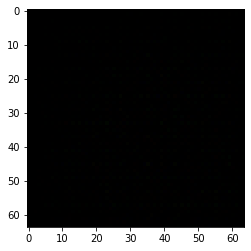

In [18]:
# Feed noise into G and see what we get

test_img = g(rand_noise_vec)

# print(test_img)

for img in test_img:
  plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


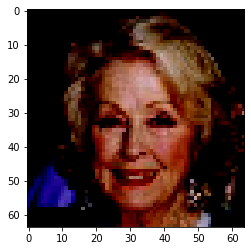

In [19]:
# Sampling random images from the dataset

def get_image_samples(n_samples):
  return(ds[np.random.randint(ds.shape[0], size=n_samples)])

plt.imshow(get_image_samples(1)[0])

In [20]:
# Training loop

EPOCHS = 1
D_STEPS = 1
G_STEPS = 1
BATCH_SIZE = 2

# Set seed
np.random.seed(1)

# Optimizers
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Losses

# Format from https://www.tensorflow.org/tutorials/generative/dcgan:
def d_loss(real_predictions, fake_predictions):

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_predictions), 
                                                   real_predictions)
  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_predictions),
                                                   fake_predictions)
  # Sum and return losses
  return real_loss + fake_loss

def g_loss(d_values):

  # Binary Crossentropy between the Discriminator outputs and 1 (which we'd like 
  # the Discriminator outputs to be)
  loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_values),
                                              d_values)
  return loss


# Training step definitions
# Compiled for training

@tf.function
def d_train_step(fake, real):

  with tf.GradientTape() as d_tape:
    # Run Discriminator and get loss
    loss = d_loss(d(real, training=True), d(fake, training=True))

  print(loss)
  print(d_tape)
  # Get all Discriminator gradients with GradientTape
  d_grad = d_tape.gradient(loss, d.trainable_variables)
  print(d_grad)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_grad, d.trainable_variables))

@tf.function
def g_train_step():

  with tf.GradientTape() as g_tape:
    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator (fake) examples from the noise
    g_examples = g(noise_samples)

    d_values = d(g_examples, training=True)

    # Run Discriminator, get values
    print(d_values[0][0])

    # Get loss
    loss = g_loss(d_values)

  # print(loss)
  # print(g_tape)
  print(g.trainable_variables)
  # Use GradientTape to get all Generator gradients
  g_grad = g_tape.gradient(loss, g.trainable_variables)
  # g_grad = tf.gradients(loss, g.trainable_variables)
  print(g_grad)

  # Apply gradients
  g_optimizer.apply_gradients(zip(g_grad, g.trainable_variables))


for i in range(EPOCHS):

  for j in range(D_STEPS):

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Sample real examples from dataset
    data_examples = get_image_samples(BATCH_SIZE)

    # Train Discriminator to distinguish between the two
    d_train_step(g_examples, data_examples)

  for j in range(G_STEPS):

    # Train Generator to maximize the probability of tricking the discriminator
    g_train_step()

# g_examples


Tensor("add:0", shape=(), dtype=float32)
[<tf.Tensor 'AddN_6:0' shape=(5, 5, 3, 16) dtype=float32>, <tf.Tensor 'AddN_7:0' shape=(16,) dtype=float32>, <tf.Tensor 'AddN_8:0' shape=(16,) dtype=float32>, <tf.Tensor 'AddN_9:0' shape=(16,) dtype=float32>, <tf.Tensor 'AddN_10:0' shape=(5, 5, 16, 32) dtype=float32>, <tf.Tensor 'AddN_11:0' shape=(32,) dtype=float32>, <tf.Tensor 'AddN_12:0' shape=(32,) dtype=float32>, <tf.Tensor 'AddN_13:0' shape=(32,) dtype=float32>, <tf.Tensor 'AddN_14:0' shape=(5, 5, 32, 64) dtype=float32>, <tf.Tensor 'AddN_15:0' shape=(64,) dtype=float32>, <tf.Tensor 'AddN_16:0' shape=(64,) dtype=float32>, <tf.Tensor 'AddN_17:0' shape=(64,) dtype=float32>, <tf.Tensor 'AddN_18:0' shape=(5, 5, 64, 128) dtype=float32>, <tf.Tensor 'AddN_19:0' shape=(128,) dtype=float32>, <tf.Tensor 'AddN_20:0' shape=(128,) dtype=float32>, <tf.Tensor 'AddN_21:0' shape=(128,) dtype=float32>, <tf.Tensor 'AddN_22:0' shape=(2048, 1) dtype=float32>, <tf.Tensor 'AddN_23:0' shape=(1,) dtype=float32>, <t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


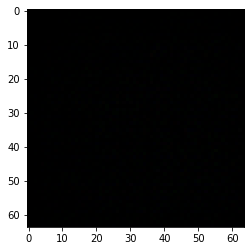

In [ ]:
plt.imshow(g_examples[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


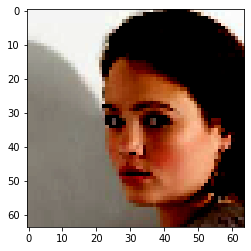

In [ ]:
plt.imshow(data_examples[0])

In [ ]:
# Prepare data

real_ds = tf.keras.utils.image_dataset_from_directory('/content/CelebA/img_align_celeba/', 
                                                      validation_split=0.1, 
                                                      subset='training', seed=1)


Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: ignored

In [ ]:
# Load dataset

import tensorflow_datasets as tfds

ds = tfds.load('celeb_a', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

KeyError: ignored